##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 훈련 후 float16 양자화

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_float16_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lite/performance/post_training_float16_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lite/performance/post_training_float16_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lite/performance/post_training_float16_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

## 개요

[TensorFlow Lite는](https://www.tensorflow.org/lite/) 이제 TensorFlow에서 TensorFlow Lite의 flat buffer 형식으로 모델을 변환하는 동안 가중치를 16bit 부동 소수점 값으로 변환하는 것을 지원합니다. 그 결과 모델 크기가 2배 감소합니다. GPU와 같은 일부 하드웨어는 감소한 정밀도 산술로 기본적으로 계산할 수 있으므로 기존 부동 소수점 실행보다 속도가 향상됩니다. Tensorflow Lite GPU 대리자는 이러한 방식으로 실행되도록 구성될 수 있습니다. 그러나 float16 가중치로 변환된 모델은 추가 수정없이도 CPU에서 계속 실행될 수 있습니다. float16 가중치는 첫 번째 추론 이전에 float32로 업 샘플링됩니다. 이를 통해 지연 시간과 정확성에 미치는 영향을 최소화하는 대신 모델 크기를 크게 줄일 수 있습니다.

이 가이드에서는 MNIST 모델을 처음부터 훈련하고 TensorFlow에서 정확성을 확인한 다음 모델을 float16 양자화를 사용하여 Tensorflow Lite flatbuffer로 변환합니다. 마지막으로 변환된 모델의 정확성을 확인하고 원래 float32 모델과 비교합니다.

## MNIST 모델 빌드하기

### 설정

In [2]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

2022-12-15 00:55:59.580016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-15 00:55:59.580120: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-15 00:55:59.580130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


### 모델 훈련 및 내보내기

In [3]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

   1/1875 [..............................] - ETA: 1:42:52 - loss: 2.2809 - accuracy: 0.0938

  20/1875 [..............................] - ETA: 5s - loss: 2.1006 - accuracy: 0.3688     

  41/1875 [..............................] - ETA: 4s - loss: 1.8007 - accuracy: 0.5587

  62/1875 [..............................] - ETA: 4s - loss: 1.5109 - accuracy: 0.6326

  84/1875 [>.............................] - ETA: 4s - loss: 1.2884 - accuracy: 0.6849

 105/1875 [>.............................] - ETA: 4s - loss: 1.1476 - accuracy: 0.7143

 126/1875 [=>............................] - ETA: 4s - loss: 1.0405 - accuracy: 0.7383

 147/1875 [=>............................] - ETA: 4s - loss: 0.9526 - accuracy: 0.7587

 168/1875 [=>............................] - ETA: 4s - loss: 0.8860 - accuracy: 0.7736

 189/1875 [==>...........................] - ETA: 4s - loss: 0.8277 - accuracy: 0.7865

 209/1875 [==>...........................] - ETA: 4s - loss: 0.7895 - accuracy: 0.7962

 229/1875 [==>...........................] - ETA: 4s - loss: 0.7567 - accuracy: 0.8043

 250/1875 [===>..........................] - ETA: 4s - loss: 0.7170 - accuracy: 0.8141

 271/1875 [===>..........................] - ETA: 3s - loss: 0.6864 - accuracy: 0.8208

 292/1875 [===>..........................] - ETA: 3s - loss: 0.6602 - accuracy: 0.8269

 313/1875 [====>.........................] - ETA: 3s - loss: 0.6404 - accuracy: 0.8314

 334/1875 [====>.........................] - ETA: 3s - loss: 0.6227 - accuracy: 0.8353

 356/1875 [====>.........................] - ETA: 3s - loss: 0.6053 - accuracy: 0.8388

 377/1875 [=====>........................] - ETA: 3s - loss: 0.5911 - accuracy: 0.8421

 399/1875 [=====>........................] - ETA: 3s - loss: 0.5744 - accuracy: 0.8459

 420/1875 [=====>........................] - ETA: 3s - loss: 0.5590 - accuracy: 0.8492

 441/1875 [======>.......................] - ETA: 3s - loss: 0.5477 - accuracy: 0.8525

 462/1875 [======>.......................] - ETA: 3s - loss: 0.5358 - accuracy: 0.8553

 483/1875 [======>.......................] - ETA: 3s - loss: 0.5246 - accuracy: 0.8584

 504/1875 [=======>......................] - ETA: 3s - loss: 0.5157 - accuracy: 0.8609

 525/1875 [=======>......................] - ETA: 3s - loss: 0.5071 - accuracy: 0.8631

 546/1875 [=======>......................] - ETA: 3s - loss: 0.4968 - accuracy: 0.8653

 567/1875 [========>.....................] - ETA: 3s - loss: 0.4907 - accuracy: 0.8668

 589/1875 [========>.....................] - ETA: 3s - loss: 0.4811 - accuracy: 0.8695

 611/1875 [========>.....................] - ETA: 3s - loss: 0.4756 - accuracy: 0.8710

 632/1875 [=========>....................] - ETA: 3s - loss: 0.4673 - accuracy: 0.8732

 654/1875 [=========>....................] - ETA: 2s - loss: 0.4606 - accuracy: 0.8747

 676/1875 [=========>....................] - ETA: 2s - loss: 0.4559 - accuracy: 0.8760

 696/1875 [==========>...................] - ETA: 2s - loss: 0.4510 - accuracy: 0.8771

 716/1875 [==========>...................] - ETA: 2s - loss: 0.4454 - accuracy: 0.8784

 737/1875 [==========>...................] - ETA: 2s - loss: 0.4400 - accuracy: 0.8798

 758/1875 [===========>..................] - ETA: 2s - loss: 0.4339 - accuracy: 0.8814

 779/1875 [===========>..................] - ETA: 2s - loss: 0.4284 - accuracy: 0.8833

 800/1875 [===========>..................] - ETA: 2s - loss: 0.4237 - accuracy: 0.8843

 820/1875 [============>.................] - ETA: 2s - loss: 0.4183 - accuracy: 0.8855

 840/1875 [============>.................] - ETA: 2s - loss: 0.4156 - accuracy: 0.8864

 860/1875 [============>.................] - ETA: 2s - loss: 0.4113 - accuracy: 0.8876

 880/1875 [=============>................] - ETA: 2s - loss: 0.4066 - accuracy: 0.8889

 900/1875 [=============>................] - ETA: 2s - loss: 0.4047 - accuracy: 0.8895

 921/1875 [=============>................] - ETA: 2s - loss: 0.4003 - accuracy: 0.8907

 942/1875 [==============>...............] - ETA: 2s - loss: 0.3958 - accuracy: 0.8918

 963/1875 [==============>...............] - ETA: 2s - loss: 0.3912 - accuracy: 0.8930

 984/1875 [==============>...............] - ETA: 2s - loss: 0.3873 - accuracy: 0.8941

1005/1875 [===============>..............] - ETA: 2s - loss: 0.3838 - accuracy: 0.8950

1025/1875 [===============>..............] - ETA: 2s - loss: 0.3799 - accuracy: 0.8962

1046/1875 [===============>..............] - ETA: 2s - loss: 0.3774 - accuracy: 0.8969

1067/1875 [================>.............] - ETA: 1s - loss: 0.3742 - accuracy: 0.8978

1088/1875 [================>.............] - ETA: 1s - loss: 0.3706 - accuracy: 0.8987

1109/1875 [================>.............] - ETA: 1s - loss: 0.3664 - accuracy: 0.8998

1130/1875 [=================>............] - ETA: 1s - loss: 0.3628 - accuracy: 0.9006

1151/1875 [=================>............] - ETA: 1s - loss: 0.3602 - accuracy: 0.9012

1172/1875 [=================>............] - ETA: 1s - loss: 0.3571 - accuracy: 0.9020

1193/1875 [==================>...........] - ETA: 1s - loss: 0.3545 - accuracy: 0.9028

1214/1875 [==================>...........] - ETA: 1s - loss: 0.3520 - accuracy: 0.9035

1235/1875 [==================>...........] - ETA: 1s - loss: 0.3484 - accuracy: 0.9044

1256/1875 [===================>..........] - ETA: 1s - loss: 0.3468 - accuracy: 0.9050

1276/1875 [===================>..........] - ETA: 1s - loss: 0.3441 - accuracy: 0.9057

1296/1875 [===================>..........] - ETA: 1s - loss: 0.3427 - accuracy: 0.9061

1317/1875 [====================>.........] - ETA: 1s - loss: 0.3397 - accuracy: 0.9068

1338/1875 [====================>.........] - ETA: 1s - loss: 0.3372 - accuracy: 0.9076

1359/1875 [====================>.........] - ETA: 1s - loss: 0.3347 - accuracy: 0.9083

1379/1875 [=====================>........] - ETA: 1s - loss: 0.3325 - accuracy: 0.9087

1400/1875 [=====================>........] - ETA: 1s - loss: 0.3304 - accuracy: 0.9093

1421/1875 [=====================>........] - ETA: 1s - loss: 0.3283 - accuracy: 0.9097

1443/1875 [======================>.......] - ETA: 1s - loss: 0.3259 - accuracy: 0.9101

1464/1875 [======================>.......] - ETA: 1s - loss: 0.3244 - accuracy: 0.9105

1485/1875 [======================>.......] - ETA: 0s - loss: 0.3222 - accuracy: 0.9110

1507/1875 [=======================>......] - ETA: 0s - loss: 0.3202 - accuracy: 0.9117

1529/1875 [=======================>......] - ETA: 0s - loss: 0.3178 - accuracy: 0.9123

1551/1875 [=======================>......] - ETA: 0s - loss: 0.3157 - accuracy: 0.9128

1573/1875 [========================>.....] - ETA: 0s - loss: 0.3139 - accuracy: 0.9133

1595/1875 [========================>.....] - ETA: 0s - loss: 0.3120 - accuracy: 0.9138

1617/1875 [========================>.....] - ETA: 0s - loss: 0.3100 - accuracy: 0.9143

1638/1875 [=========================>....] - ETA: 0s - loss: 0.3082 - accuracy: 0.9148

1659/1875 [=========================>....] - ETA: 0s - loss: 0.3062 - accuracy: 0.9153

1681/1875 [=========================>....] - ETA: 0s - loss: 0.3045 - accuracy: 0.9159

1702/1875 [==========================>...] - ETA: 0s - loss: 0.3034 - accuracy: 0.9161

1723/1875 [==========================>...] - ETA: 0s - loss: 0.3015 - accuracy: 0.9166

1744/1875 [==========================>...] - ETA: 0s - loss: 0.2996 - accuracy: 0.9171

1765/1875 [===========================>..] - ETA: 0s - loss: 0.2979 - accuracy: 0.9175

1785/1875 [===========================>..] - ETA: 0s - loss: 0.2961 - accuracy: 0.9179

1806/1875 [===========================>..] - ETA: 0s - loss: 0.2944 - accuracy: 0.9185

1827/1875 [============================>.] - ETA: 0s - loss: 0.2928 - accuracy: 0.9190

1847/1875 [============================>.] - ETA: 0s - loss: 0.2918 - accuracy: 0.9192

1867/1875 [============================>.] - ETA: 0s - loss: 0.2905 - accuracy: 0.9195

1875/1875 [==============================] - 9s 3ms/step - loss: 0.2901 - accuracy: 0.9197 - val_loss: 0.1384 - val_accuracy: 0.9614


예를 들어, 단일 epoch에 대해서만 모델을 훈련시켰으므로 ~96% 정확성으로만 훈련합니다.

### TensorFlow Lite 모델로 변환하기

TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert)를 사용하여 이제 훈련된 모델을 TensorFlow Lite 모델로 변환할 수 있습니다.

`TFLiteConverter`를 사용하여 모델을 로드합니다.

In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp6lyb31lw/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp6lyb31lw/assets


2022-12-15 00:56:14.848472: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 00:56:14.848515: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


`.tflite` 파일에 작성합니다.

In [5]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [6]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84820

대신 모델을 내보낼 때 float16으로 양자화하려면 먼저 기본 최적화를 사용하도록 `optimizations` 플래그를 지정합니다. 그런 다음 float16이 대상 플랫폼에서 지원되는 유형임을 지정합니다.

In [7]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

마지막으로 평소와 같이 모델을 변환합니다. 기본적으로 변환된 모델은 호출 편의를 위해 여전히 float 입력 및 출력을 사용합니다.

In [8]:
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"mnist_model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpb6hmdxdl/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpb6hmdxdl/assets


2022-12-15 00:56:15.826625: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-15 00:56:15.826673: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


44624

결과 파일이 약 `1/2` 크기인지 확인하세요.

In [9]:
!ls -lh {tflite_models_dir}

total 128K
-rw-rw-r-- 1 kbuilder kbuilder 83K Dec 15 00:56 mnist_model.tflite
-rw-rw-r-- 1 kbuilder kbuilder 44K Dec 15 00:56 mnist_model_quant_f16.tflite


## TensorFlow Lite 모델 실행하기

Python TensorFlow Lite 인터프리터를 사용하여 TensorFlow Lite 모델을 실행합니다.

### 인터프리터에 모델 로드하기

In [10]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [11]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

### 하나의 이미지에서 모델 테스트하기

In [12]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

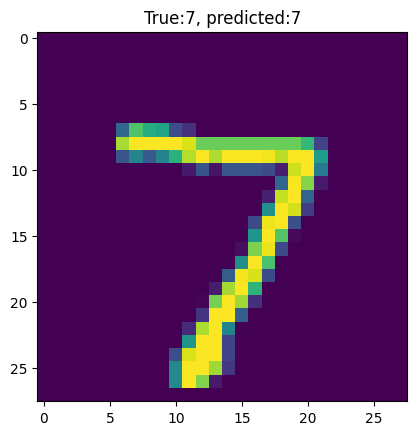

In [13]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [14]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index = interpreter_fp16.get_output_details()[0]["index"]

interpreter_fp16.set_tensor(input_index, test_image)
interpreter_fp16.invoke()
predictions = interpreter_fp16.get_tensor(output_index)

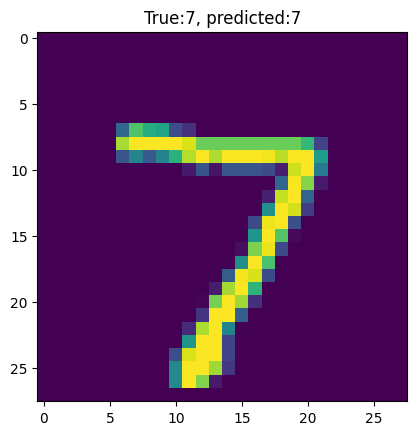

In [15]:
plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

### 모델 평가하기

In [16]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [17]:
print(evaluate_model(interpreter))

0.9614


float16 양자화된 모델에 대한 평가를 반복하여 다음을 얻습니다.

In [18]:
# NOTE: Colab runs on server CPUs. At the time of writing this, TensorFlow Lite
# doesn't have super optimized server CPU kernels. For this reason this may be
# slower than the above float interpreter. But for mobile CPUs, considerable
# speedup can be observed.
print(evaluate_model(interpreter_fp16))

0.9614


이 예에서는 정확성 차이가 없이 모델을 float16으로 양자화했습니다.

GPU에서 fp16 양자화 모델을 평가하는 것도 가능합니다. 감소된 정밀도 값으로 모든 산술을 수행하려면 다음과 같이 앱에서 `TfLiteGPUDelegateOptions` 구조체를 만들고 `precision_loss_allowed`를 `1`로 설정해야 합니다.

```
//Prepare GPU delegate.
const TfLiteGpuDelegateOptions options = {
  .metadata = NULL,
  .compile_options = {
    .precision_loss_allowed = 1,  // FP16
    .preferred_gl_object_type = TFLITE_GL_OBJECT_TYPE_FASTEST,
    .dynamic_batch_enabled = 0,   // Not fully functional yet
  },
};
```

TFLite GPU 대리자 및 애플리케이션에서 사용하는 방법에 대한 자세한 설명서는 [여기에서](https://www.tensorflow.org/lite/performance/gpu_advanced?source=post_page---------------------------) 찾을 수 있습니다